In [197]:
from HH_Lukas import HouseholdSpecializationModelClass as HC
from types import SimpleNamespace
import numpy as np  
from scipy import optimize
import ipywidgets as widgets
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib import cm
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Question 1

#### Testing
First, we solve for one set of parameters. Later on, we'll build up a loop.  

In [219]:
a = HC() #Import the whole model
a.par.alpha = 0.25 #Set parameters
a.par.sigma = 0.5
a_1 = a.solve_discrete() #solve the model


#Get hours worked for females and males and compute ratio
HF_1 = a_1.HF  
HM_1 = a_1.HM
HFHM_1=HF_1/HM_1
print('The ratio of female to male hours worked at home is ', HFHM_1)


/Users/l/Desktop/Programming/Intro_Num-1/HH_Lukas.py:66: RuntimeWarning: divide by zero encountered in reciprocal
  H = ((1-par.alpha)*HM**(power1)+par.alpha*HF**(power1))**(power2)
/Users/l/Desktop/Programming/Intro_Num-1/HH_Lukas.py:66: RuntimeWarning: invalid value encountered in reciprocal
  H = ((1-par.alpha)*HM**(power1)+par.alpha*HF**(power1))**(power2)
/Users/l/Desktop/Programming/Intro_Num-1/HH_Lukas.py:70: RuntimeWarning: invalid value encountered in reciprocal
  utility = np.fmax(Q,1e-8)**(1-par.rho)/(1-par.rho)


The ratio of female to male hours worked at home is  0.5454545454545454


### Loop

#### Initialize

In [199]:
#Parameters
alphas = np.array([0.25, 0.5, 0.75])
sigmas = np.array([0.5, 1.0, 1.5])
#Initialize arrays for hours worked at home for males and females
HM = np.zeros(9) 
HF = np.zeros(9)

#### Indexing
Figure out an index for all nine possible combinations of the parameters. The combinations can be found using the Cartesian product of the "alphas" and "sigmas" arrays.


In [200]:
for i, val1 in enumerate(alphas): 
    for j, val2 in enumerate(sigmas):
        index = i * len(sigmas) + j
        print(index, '=',i, '*', len(sigmas), '+', j)

0 = 0 * 3 + 0
1 = 0 * 3 + 1
2 = 0 * 3 + 2
3 = 1 * 3 + 0
4 = 1 * 3 + 1
5 = 1 * 3 + 2
6 = 2 * 3 + 0
7 = 2 * 3 + 1
8 = 2 * 3 + 2


In [201]:
print('Example: the combination of the alpha with position 1 (0.5) and the sigma with position 2 (1.5) will land in position', 1* len(sigmas) + 2  )

Example: the combination of the alpha with position 1 (0.5) and the sigma with position 2 (1.5) will land in position 5


### Loop

In [202]:
for i, val1 in enumerate(alphas): 
    a.par.alpha = val1  #Set the parameter of outer loop
    for j, val2 in enumerate(sigmas):
        a.par.sigma = val2 #Set parameter of inner loop 
        index = i * len(sigmas) + j 
        HM[index] = a.solve_discrete().HM #Solve and extract hours worked at home
        HF[index] = a.solve_discrete().HF

Home_ratios = (HF/HM).reshape((3,3))
print(Home_ratios)

[[0.54545455 0.30769231 0.21428571]
 [1.         1.         1.        ]
 [1.83333333 3.25       4.66666667]]


In [203]:
np.meshgrid([0,0,0,0], [0])

[array([[0, 0, 0, 0]]), array([[0, 0, 0, 0]])]

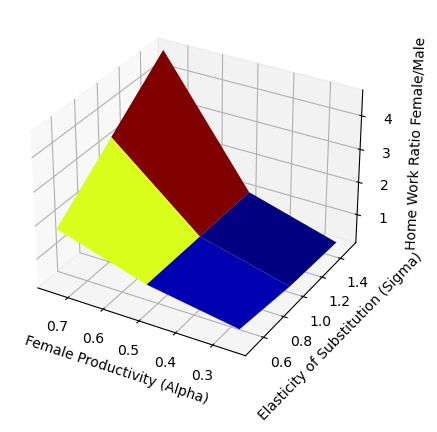

In [204]:

alphas_grid, sigmas_grid = np.meshgrid(alphas,sigmas,indexing='ij') #Prepare 3d plot by repeating each value in the arrays sigmas and alphas
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
#ax.set_xlabel('Alphas')
ax.set_xlabel(xlabel= 'Female Productivity (Alpha)')
ax.set_ylabel('Elasticity of Substitution (Sigma)')
ax.set_zlabel('        Home Work Ratio Female/Male')
ax.invert_xaxis() #So Origo is in the front right corner
ax.plot_surface(alphas_grid,sigmas_grid,Home_ratios,cmap=cm.jet)


### Interpretation
Here we see that when female and male productivity are equal (alpha = 0.5) and their labor is highly subsititutable (high sigma), the ratio of home work is around 1. Implying equal division of chores. On the other hand, if men are more productive at home chores (alpha < 0.5) they will work more than females (ratio below 1) given a high elasticity of substituition. 

## Question 2
Log-log plotting the optimal ratio of home work for different levels of female wages.

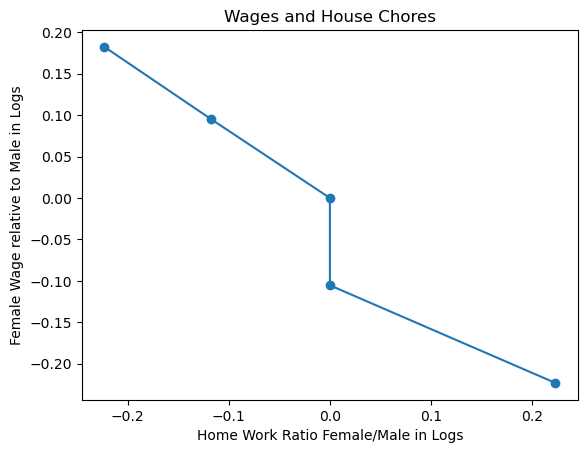

In [205]:
a.par.alpha = 0.5 #Re-set parameters
a.par.sigma = 1
assert np.array_equal(a.par.wF_vec, np.linspace(0.8, 1.2, 5)) #Check we have the correct array of female wages stored
res = a.solve_wF_vec(discrete=True) #Loops through the values, solves the model and stores the hours worked at home. 
Home_ratios = res.Home_ratios #Above function returns the Home_ratios vector

fig, ax = plt.subplots() #Start plotting
ax.plot(np.log(Home_ratios), np.log(a.par.wF_vec), 'o-') #As male wage is equal to one, division is not necessary. 

ax.set_xlabel('Home Work Ratio Female/Male in Logs')
ax.set_ylabel('Female Wage relative to Male in Logs')
ax.set_title('Wages and House Chores')

plt.show()

#### Interpretation

As expected, when female wage is high relative to mens', females pick up less home work and vice versa. 

## Question 3
In the continous choice set of labor allocated, we use a gradient based optimizer. These types of optimizers depend on the starting point. For types of work for males and females, we chose the averages for different types of female wages as found from the discrete solution.

In [206]:
average_guess = [res.LM.mean(),res.HM.mean() ,res.LF.mean(), res.HF.mean()]
print(average_guess) 
assert np.array_equal(a.par.guess, average_guess)

[4.5, 4.5, 4.4, 4.4]


#### For one value of female wage
First we solve for the optimal allocation of HF/HM for one particular value of female wage.

In [207]:
a.solve_continuous(do_print=True)

LM = 3.1130
HM = 4.8179
LF = 5.5165
HF = 3.9905


namespace(LM=3.113042308884136,
          HM=4.817860520055413,
          LF=5.5165398026072126,
          HF=3.9904860238398636)

##### Second local maximum
Unsuprisingly, we note that not working at all, is a local maximum. Nevertheless with a lower utility than the above presented solution. 


In [208]:
a.par.guess = [0, 0, 0, 0]
a.solve_continuous(do_print=True)
print('Utility from not working at all = ', a.calc_utility(LM= 0 , HM= 0, LF =0, HF= 0))

LM = 0.0000
HM = 0.0000
LF = 0.0000
HF = 0.0000
Utility from not working at all =  -100000000.0


#### Looping through and plotting

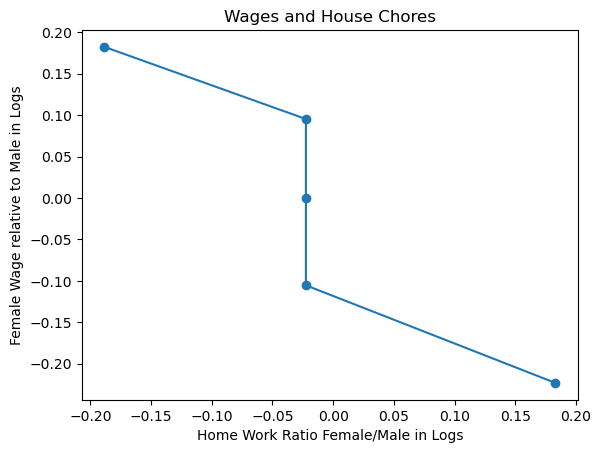

In [209]:
a.par.guess = average_guess
assert np.array_equal(a.par.guess, average_guess)
assert np.array_equal(a.par.wF_vec, np.linspace(0.8, 1.2, 5)) #Check we have the correct array of female wages stored
res3 = a.solve_wF_vec(discrete=False) #Loops through the values, solves the model and stores the hours worked at home. 
Home_ratios = res3.Home_ratios #Above function returns the Home_ratios vector

fig, ax = plt.subplots() #Start plotting
ax.plot(np.log(Home_ratios), np.log(a.par.wF_vec), 'o-') #As male wage is equal to one, division is not necessary. 

ax.set_xlabel('Home Work Ratio Female/Male in Logs')
ax.set_ylabel('Female Wage relative to Male in Logs')
ax.set_title('Wages and House Chores')

plt.show()

#### Interpretation
Here again, we see that if females earn higher wages outside, they work less in the home. Contrary to the discrete case, we do not observe jumps in the work provided. 
Note that in our example, the labor provided by males and females is equally productive at home and perfectly substitutable (sigma = 1 and alpha 0.5). This implies that equal wage should lead to equal work allocation. Our intution is confirmed by both the continous and discrete graph as approximately $f(x = 0) = 0$.

## Question 4 OLS 



### Creating our dependent and explanatory variables

In [210]:
y = np.log(Home_ratios).reshape(-1,1) #From the previous question
x = np.column_stack(((np.ones((5,1)),np.log(np.linspace(0.8,1.2,5)).reshape(-1,1)))) #Adding a constant and appending it to our points for WF/WM


#### Initial guess
First we try to run a regular OLS for the initial values (alpha = 0.5, sigma =1 )

In [211]:
beta_initial = np.linalg.inv(x.T@x)@x.T@y #Old faithful Beta ols
print('Estimates: beta_0 =', beta_initial[0], 'and beta_1 = ', beta_initial[1])

Estimates: beta_0 = [-0.02206892] and beta_1 =  [-0.73709258]


In [233]:
a.par.alpha = 0.5 #Re-set parameters
a.par.sigma = 1
a.solve_wF_vec()

namespace(Home_ratios=array([1.20080059, 0.97777778, 0.97777778, 0.97777778, 0.82826931]),
          LM=array([5.92921183, 4.5       , 4.5       , 4.5       , 3.11304231]),
          HM=array([4.10604582, 4.5       , 4.5       , 4.5       , 4.81786052]),
          LF=array([2.96570362, 4.4       , 4.4       , 4.4       , 5.5165398 ]),
          HF=array([4.93054222, 4.4       , 4.4       , 4.4       , 3.99048602]))

In [234]:
a.sol.HF_vec

array([4.93054222, 4.4       , 4.4       , 4.4       , 3.99048602])

In [235]:
a.run_regression()
a.sol.beta0

-0.022068923029575475